plot profiles

In [1]:
# python modules
import copy
import re
import random
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
### parameters for plot profiles
domain_param = {}
for domain in ['TSS', 'TSS-TTS']:
    profile_len = 1000
    moving_average_win = 20
    pad_len = moving_average_win/2

    if domain == 'TSS':
        up_win = 2500
        down_win = 5000
        left_len = int(round(up_win*float(profile_len)/(up_win+down_win+1)))
        right_len = profile_len - left_len - 1
        offset = -left_len
        xtick_locs = [-left_len + pad_len, 0, right_len - pad_len]
        xtick_labels = ["-2.5kb", "TSS", "5kb"]


    elif domain == 'TSS-TTS':
        domain_frac = 0.6
        margin_frac = 1.0 - domain_frac
        up_win = 5000
        down_win = 2500
        left_len = int((margin_frac*profile_len)*(float(up_win)/(up_win + down_win)))
        right_len = int((margin_frac*profile_len)*(float(down_win)/(up_win + down_win)))
        offset = -left_len
        xtick_locs = [-left_len+pad_len,
                      0,
                      int(domain_frac*profile_len),
                      int(domain_frac*profile_len) + right_len - pad_len ]
        xtick_labels = ["-5kb", "TSS", "TTS", "2.5kb"]


    param = {}
    param['moving_average_win'] = moving_average_win
    param['profile_len'] = profile_len
    param['up_win'] = up_win
    param['down_win'] = down_win
    param['pad_len'] = pad_len
    param['left_len'] = left_len
    param['right_len'] = right_len
    param['offset'] = offset
    param['xtick_locs'] = xtick_locs
    param['xtick_labels'] = xtick_labels

    if domain == 'TSS-TTS':
        param['domain_frac'] = domain_frac
        param['margin_frac'] = margin_frac

    domain_param[domain] = param
    

In [7]:
### set data information (fname/field) and key
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

#dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_deep_chr([0-9XY])+_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:WT_NCP_sp_8_1rep_deep':(1, 'mCD8T:WT', 'score')},
#              'mCD8T:DFMO_NCP_sp_1rep_deep_chr([0-9XY])+_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:DFMO_NCP_sp_8_1rep_deep':(1, 'mCD8T:DFMO', 'score')},
#              'mCD8T:ODCKO_NCP_sp_1rep_deep_chr([0-9XY])+_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:ODCKO_NCP_sp_8_1rep_deep':(1, 'mCD8T:ODCKO', 'score')},
#              'mCD8T:WT_NCP_sp_2rep_deep_chr([0-9XY])+_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:WT_NCP_sp_8_2rep_deep':(2, 'mCD8T:WT', 'score')},
#              'mCD8T:DFMO_NCP_sp_2rep_deep_chr([0-9XY])+_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:DFMO_NCP_sp_8_2rep_deep':(2, 'mCD8T:DFMO', 'score')},
#              'mCD8T:ODCKO_NCP_sp_2rep_deep_chr([0-9XY])+_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:ODCKO_NCP_sp_8_2rep_deep':(2, 'mCD8T:ODCKO', 'score')}
#              }

#dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:WT_NCP_sp_8_1rep_deep':(1, 'mCD8T:WT', 'score')},
#              'mCD8T:DFMO_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:DFMO_NCP_sp_8_1rep_deep':(1, 'mCD8T:DFMO', 'score')},
#              'mCD8T:ODCKO_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:ODCKO_NCP_sp_8_1rep_deep':(1, 'mCD8T:ODCKO', 'score')},
#              'mCD8T:WT_NCP_sp_2rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:WT_NCP_sp_8_2rep_deep':(2, 'mCD8T:WT', 'score')},
#              'mCD8T:DFMO_NCP_sp_2rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:DFMO_NCP_sp_8_2rep_deep':(2, 'mCD8T:DFMO', 'score')},
#              'mCD8T:ODCKO_NCP_sp_2rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
#              {'mCD8T:ODCKO_NCP_sp_8_2rep_deep':(2, 'mCD8T:ODCKO', 'score')}
#              }



dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
               {'H3K27ac_new_1rep':(1, 'mCD8T:WT', 'H3K27ac'),
                'H3K27ac_new_2rep':(2, 'mCD8T:WT', 'H3K27ac'),
                'H3K27ac_new_3rep':(3, 'mCD8T:WT', 'H3K27ac'),
                'H3K27me3_new_1rep':(1, 'mCD8T:WT', 'H3K27me3'),
                'H3K27me3_new_2rep':(2, 'mCD8T:WT', 'H3K27me3'),
                'H3K27me3_new_3rep':(3, 'mCD8T:WT', 'H3K27me3')},
               'mCD8T:DFMO_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
               {'H3K27ac_new_1rep':(1, 'mCD8T:DFMO', 'H3K27ac'),
                'H3K27ac_new_2rep':(2, 'mCD8T:DFMO', 'H3K27ac'),
                'H3K27ac_new_3rep':(3, 'mCD8T:DFMO', 'H3K27ac'),
                'H3K27me3_new_1rep':(1, 'mCD8T:DFMO', 'H3K27me3'),
                'H3K27me3_new_2rep':(2, 'mCD8T:DFMO', 'H3K27me3'),
                'H3K27me3_new_3rep':(3, 'mCD8T:DFMO', 'H3K27me3')}
               }


In [8]:
### loading profile data
dkey_geneID_profile = {}
for fkey in dinfo_dkey:
    field_dkey = dinfo_dkey[fkey]
    for fname in glob.glob(path + '*'):
        if not re.match(fkey, fname.rsplit('/')[-1]):
            continue
        print "loading %s" % (fname.rsplit('/')[-1])
        field_geneID_profile = load_file.read_profile(fname,
                                                      name_choice=field_dkey.keys())

        for field, dkey in field_dkey.items():
            print "\t %s" % (field)
            geneID_profile = field_geneID_profile[field]
            if dkey not in dkey_geneID_profile:
                dkey_geneID_profile[dkey] = {}
            dkey_geneID_profile[dkey].update(geneID_profile)
            

loading mCD8T:DFMO_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep
loading mCD8T:WT_NCP_sp_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz


	 H3K27me3_new_2rep
	 H3K27me3_new_1rep
	 H3K27ac_new_1rep
	 H3K27me3_new_3rep
	 H3K27ac_new_2rep
	 H3K27ac_new_3rep


In [9]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/GTF/'
GTF_fname = 'ENCFF871VGR.gtf'

geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=cell_chrnames['mCD8T:WT'])

In [10]:
### read RNA-seq data and compute FPKM
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/RNAseq/'
RNAseq_fname = 'GSE136898_rawCounts.txt'

## get mean read counts
exp_gname_counts = load_file.read_tabular_file (RNAseq_path + RNAseq_fname,
                                                mode="col")

gname_counts1 = exp_gname_counts['group4Stim_1']
gname_counts2 = exp_gname_counts['group4Stim_3']

total_counts = 0.0
gname_counts = {}
for gname in gname_counts1:
    counts = (gname_counts1[gname] + gname_counts2[gname])*0.5
    counts += 1  # add pseudo-count
    gname_counts[gname] = counts
    total_counts += counts

## compute exon lengths
geneID_exonlen = {}
for geneID in geneID_field_value:
    exons = geneID_field_value[geneID]['exons']
    length = 0
    for start, end in exons:
        length +=  end - start + 1
    geneID_exonlen[geneID] = length

## compute FPKM
geneID_FPKM = {}
for geneID in geneID_exonlen:
    try:
        gname = geneID_field_value[geneID]['geneName']
        FPM = (gname_counts[gname] / total_counts)*(10**6)
        FPKM = float(FPM)/(geneID_exonlen[geneID]/1000.0)
    except:
        continue
    geneID_FPKM[geneID] = FPKM


(1, 'mCD8T:DFMO', 'H3K27ac')


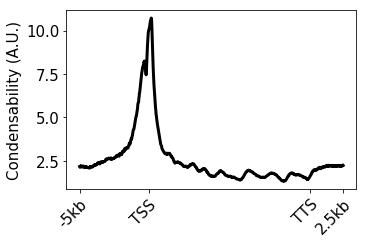

(1, 'mCD8T:DFMO', 'H3K27me3')


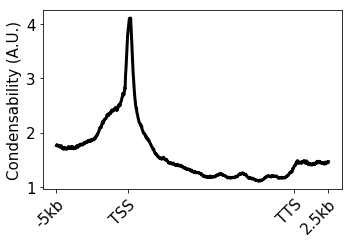

(1, 'mCD8T:WT', 'H3K27ac')


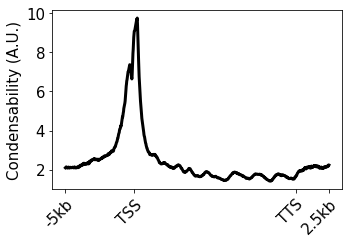

(1, 'mCD8T:WT', 'H3K27me3')


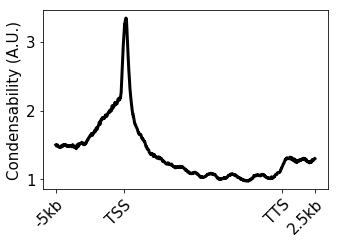

(2, 'mCD8T:DFMO', 'H3K27ac')


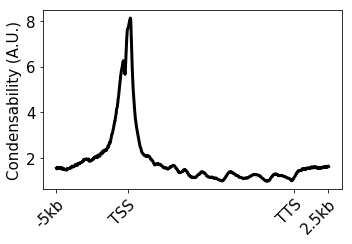

(2, 'mCD8T:DFMO', 'H3K27me3')


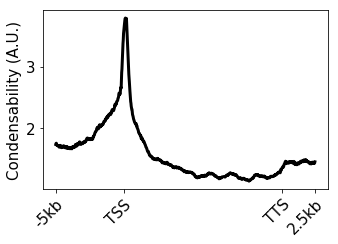

(2, 'mCD8T:WT', 'H3K27ac')


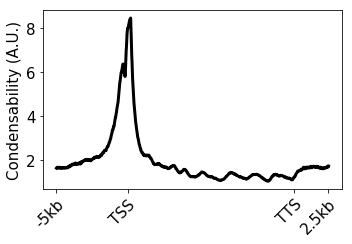

(2, 'mCD8T:WT', 'H3K27me3')


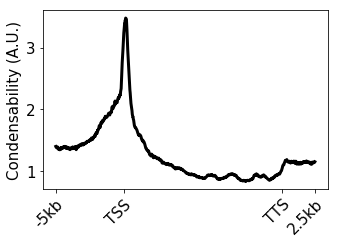

(3, 'mCD8T:DFMO', 'H3K27ac')


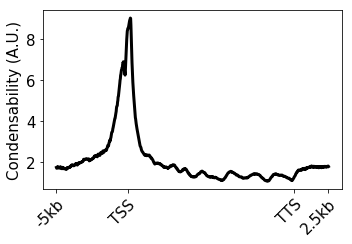

(3, 'mCD8T:DFMO', 'H3K27me3')


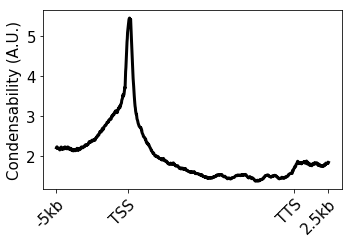

(3, 'mCD8T:WT', 'H3K27ac')


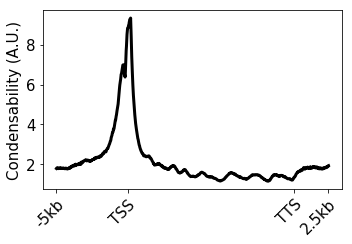

(3, 'mCD8T:WT', 'H3K27me3')


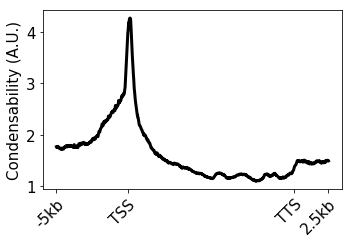

1

In [11]:
# plot mean profile
for dkey in sorted(dkey_geneID_profile):
    print dkey
    geneID_profile = dkey_geneID_profile[dkey]
    mprofile = np.nanmean(geneID_profile.values(), axis=0)
    mprofile = statis.moving_average(mprofile, 20)

    param = domain_param['TSS-TTS']

    graphics.plot_profile (mprofile,
                           offset=param['offset'],
                           pad_len=param['pad_len'],
                           xtick_locs=param['xtick_locs'],
                           xtick_labels=param['xtick_labels'],
                           ylabel='Condensability (A.U.)')
                           
1                           

In [17]:
# partition quantiles according to gene expression level
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for dkey in sorted(dkey_geneID_profile):
    print dkey
    geneID_profile = dkey_geneID_profile[dkey]
    geneIDs = set(geneID_profile.keys()) & set(geneID_FPKM.keys())
    q_geneIDs = statis.quantile_dict({geneID:geneID_FPKM[geneID] for geneID in geneIDs}, 5)

    profiles = []
    labels = []
    for i in range(len(q_geneIDs)):
        profile = np.nanmean([geneID_profile[geneID] for geneID in q_geneIDs[i]], axis=0)
        profile = statis.moving_average(profile, 20)
        profiles.append(profile)
        labels.append('FPKM quantile %d' % (i+1))
        
    graphics.plot_profile_multiple (profiles,
                                    colors=colors,
                                    alphas=[1]*len(profiles),
                                    lws=[3]*len(profiles),
                                    labels=labels,
                                    offset=param['offset'],
                                    pad_len=param['pad_len'],
                                    xtick_locs=param['xtick_locs'],
                                    xtick_labels=param['xtick_labels'],
                                    ylabel='read counts',
                                    note = '%s %s %s' % dkey,
                                    save=True,
                                    fig_width=5,
                                    fig_height=4)
        
    

(1, 'mCD8T:DFMO', 'H3K27ac')
(1, 'mCD8T:DFMO', 'H3K27me3')
(1, 'mCD8T:WT', 'H3K27ac')


(1, 'mCD8T:WT', 'H3K27me3')
(2, 'mCD8T:DFMO', 'H3K27ac')
(2, 'mCD8T:DFMO', 'H3K27me3')


(2, 'mCD8T:WT', 'H3K27ac')
(2, 'mCD8T:WT', 'H3K27me3')
(3, 'mCD8T:DFMO', 'H3K27ac')


(3, 'mCD8T:DFMO', 'H3K27me3')
(3, 'mCD8T:WT', 'H3K27ac')
(3, 'mCD8T:WT', 'H3K27me3')


In [13]:
# partition quantiles according to gene expression level
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

marks = ['H3K27ac', 'H3K27me3']
reps = [1, 2, 3]
for mark in marks:
    for rep in reps:

        print '%s (%drep)' % (mark, rep)
        dkeys = [(rep, 'mCD8T:WT', mark), (rep, 'mCD8T:DFMO', mark)]

        target_geneIDs = set(geneID_FPKM.keys())
        for dkey in dkeys:
            geneID_profile = dkey_geneID_profile[dkey]
            target_geneIDs &= set(geneID_profile.keys())
        target_geneIDs = list(target_geneIDs)

        q_geneIDs = statis.quantile({geneID:geneID_FPKM[geneID] for geneID in target_geneIDs}, 5)
        for i in range(len(q_geneIDs)):
            profiles = []
            labels = []
            for dkey in dkeys:
                geneID_profile = dkey_geneID_profile[dkey]
                profile = np.nanmean([geneID_profile[geneID] for geneID in q_geneIDs[i]], axis=0)
                profile = statis.moving_average(profile, 20)
                profiles.append(profile)
                labels.append(dkey[1].split(':')[1])

            graphics.plot_profile_multiple (profiles,
                                            colors=colors,
                                            alphas=[1]*len(profiles),
                                            lws=[3]*len(profiles),
                                            labels=labels,
                                            offset=param['offset'],
                                            pad_len=param['pad_len'],
                                            xtick_locs=param['xtick_locs'],
                                            xtick_labels=param['xtick_labels'],
                                            ylabel='read counts',
                                            title='Q' + str(i+1),
                                            fig_width=4.5,
                                            fig_height=3)
        print
            

H3K27ac (1rep)


AttributeError: 'module' object has no attribute 'quantile'

In [14]:
# partition quantiles according to gene expression level
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

marks = ['score']
reps = [1, 2]
for mark in marks:
    for rep in reps:

        print '%s (%drep)' % (mark, rep)
        dkeys = [(rep, 'mCD8T:WT', mark),
                 (rep, 'mCD8T:DFMO', mark),
                 (rep, 'mCD8T:ODCKO', mark)]

        #dkeys = [(rep, 'mCD8T:WT', mark)]
        
        target_geneIDs = set(geneID_FPKM.keys())
        for dkey in dkeys:
            geneID_profile = dkey_geneID_profile[dkey]
            target_geneIDs &= set(geneID_profile.keys())
        target_geneIDs = list(target_geneIDs)

        q_geneIDs = statis.quantile_dict({geneID:geneID_FPKM[geneID] for geneID in target_geneIDs}, 5)
        for i in range(len(q_geneIDs)):
            profiles = []
            labels = []
            for dkey in dkeys:
                geneID_profile = dkey_geneID_profile[dkey]
                profile = np.nanmean([geneID_profile[geneID] for geneID in q_geneIDs[i]], axis=0)
                profile = statis.moving_average(profile, 20)
                profiles.append(profile)
                labels.append(dkey[1].split(':')[1])

            graphics.plot_profile_multiple (profiles,
                                            colors=colors,
                                            alphas=[1]*len(profiles),
                                            lws=[3]*len(profiles),
                                            labels=labels,
                                            offset=param['offset'],
                                            pad_len=param['pad_len'],
                                            xtick_locs=param['xtick_locs'],
                                            xtick_labels=param['xtick_labels'],
                                            ylabel='read counts',
                                            title='Q' + str(i+1),
                                            note='Q' + str(i+1),
                                            save=True,
                                            fig_width=4.5,
                                            fig_height=3.3)
        print

score (1rep)


KeyError: (1, 'mCD8T:WT', 'score')

In [15]:
# plot profile heatmap
for dkey in dkey_geneID_profile:
    geneID_profile = dkey_geneID_profile[dkey]
    FPKM_geneID = sorted([(geneID_FPKM[geneID], geneID) for geneID in geneID_profile])
    geneIDs = [geneID for FPKM, geneID in FPKM_geneID]
    profiles = []
    for geneID in geneIDs:
        profile = geneID_profile[geneID]
        profile = statis.moving_average(profile, 20)
        profiles.append(profile)

    graphics.plot_profile_heatmap (profiles,
                                   offset=param['offset'],
                                   pad_len=param['pad_len'],
                                   xtick_locs=param['xtick_locs'],
                                   xtick_labels=param['xtick_labels'])

                          


KeyError: 'ENSMUSG00000065055'